# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: Agregar las librerías que hagan falta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
dataset = pd.read_csv("../data/loan_data.csv", comment="#")

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

In [4]:
dataset.head()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [5]:
dataset.TARGET.value_counts()

0    1545
1     309
Name: TARGET, dtype: int64

1) Los datos están estructurados en una serie de variables obtenidas de clientes del departamento de créditos de un banco. Proporcionan datos relevantes sobre el desempeño de 5960 préstamos con garantía hipotecaria, categorizando los mismos según hayan caído en default o no. 

2) La variable objetivo a predecir `TARGET` es binaria y etiqueta aquellos prestamos que han sido pagados y los que no(default). El valor 0 se corresponde con aquellos que han pagado el préstamo, mientras que si toma valor 1 es porque han incumplido.

3) Para cada solicitante de préstamo se registraron 12 variables de entrada o atributos que se mencionan a continuación.

  
 `LOAN`: Monto de la solicitud de préstamo
 
 `MORTDUE`: Monto adeudado de la hipoteca existente
 
 `VALUE`: Valor de la propiedad actual
 
 `YOJ`: Años en el trabajo actual
 
 `DEROG`: Número de informes importantes derogados 
 
 `DELINQ`: Número de líneas de crédito morosas
 
 `CLAGE`: Antigüedad de la línea comercial más antigua en meses
 
 `NINQ`: Número de líneas de crédito recientes
 
 `CLNO`: Número de líneas de crédito
 
`DEBTINC`: Relación deuda-ingresos

4) Los atributos más determinantes para la predicción son: `LOAN`,  `MORTDUE`, `DELINQ` y `DEBTINC`


## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


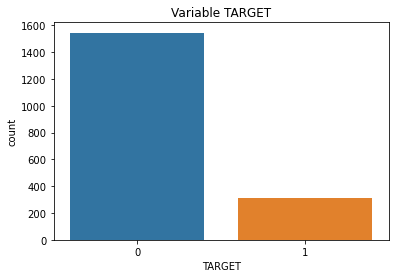

In [166]:
sns.countplot(dataset.TARGET)
plt.title("Variable TARGET")
plt.show()                      #Hay 309 créditos en default

La variable objetivo esta muy desbalanceada, por encontrarse la mayor proporción de los créditos en el grupo de aquellos que no entraron en default.

Si medimos la efectividad de nuestro modelo por la cantidad de aciertos que tuvo, sólo teniendo en cuenta a la clase mayoritaria podemos estar teniendo una falsa sensación de que el modelo funciona bien.

En este caso lo que se buscaría evitar son los Falsos Negativos, es decir, que el modelo prediga que el cliente va a pagar el prestamo siendo que en realidad caerá en default.

#### Ajustamos el modelo

SGDC es altamente sensible a la escala de las variables, por lo cual un paso fundamental antes de definir y entrenar el modelo es el escalamiento.

In [167]:
scaler=MinMaxScaler()
sgd=SGDClassifier(random_state=0)

model = make_pipeline(scaler,sgd)
model.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('sgdclassifier', SGDClassifier(random_state=0))])

#### Predecimos y obtenermos las métricas

In [168]:
y_train_pred= model.predict(X_train)
y_test_pred= model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("TESTEO")
print(classification_report(y_test, y_test_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1232
           1       0.80      0.34      0.48       251

    accuracy                           0.87      1483
   macro avg       0.84      0.66      0.70      1483
weighted avg       0.87      0.87      0.85      1483

TESTEO
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       313
           1       0.74      0.34      0.47        58

    accuracy                           0.88       371
   macro avg       0.82      0.66      0.70       371
weighted avg       0.87      0.88      0.86       371



Estamos en un caso de alta precisión y bajo recall para la clase 1, es decir que el modelo no detecta la clase muy bien pero cuando lo hace es altamente confiable. Esto también se verá en la matriz de confusión a continuación

5. Matriz de confusión

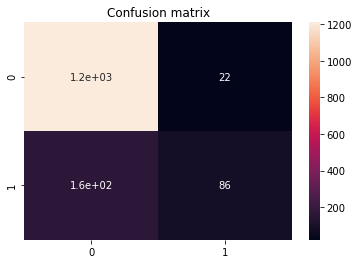

In [169]:
#Entrenamiento

cm=confusion_matrix(y_train,y_train_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")      
plt.show()

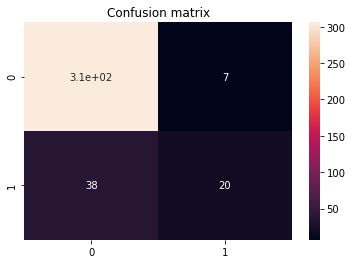

In [170]:
#Testeo

cm=confusion_matrix(y_test,y_test_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")       #Esta matriz es rara, indicaría que no hay casos en que el label sea 1?
plt.show()
#El objetivo en las matrices de confusión es maximizar los casos en la diagonal principal, que implica que tenés casos correctamente clasificados
#Acá se ve qeu tenés todo clasificado como 0 (y nada como 1=default)

Como dijimos anteriormente, el modelo predice correctamente la clase 0 pero no la clase 1. Esto es debido al alto grado de desbalanceo en la variable objetivo.
Se plantean diferentes soluciones, tales como: ajustar los parámetros del modelo utilizando "class_weight" para intentar equilibrar la clase minoritaria penalizando la mayoritaria, oversampling de la clase minoritaria o undersampling de la clase mayoritaria, entre otros.

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Definimos una grilla de parámetros

In [171]:
params={'sgd__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
        'sgd__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        'sgd__penalty':['l1','l2']}
#veamos qué tan práctico o demandante es pretender hacer tantas comparaciones. 

Hacemos la validación cruzada con el modelo de descenso de gradiente y la grilla de hiperparámetros que queremos probar.

Usaremos el parámetro "class_weight" de SGDClassifier para equilibrar la clase minoritaria durante el entrenamiento. Asimismo eligiremos otro parámetro para evaluar la validación cruzada: f1-score, tratando de maximizar los falsos positivos (que el modelo haya predicho que caerá en default siendo que no será así) y minimizando los falsos negativos (que el modelo haya predicho que no caerá en default siendo que en realidad no pagará el préstamo).

Empirically, we found that SGD converges after observing approximately 10^6 training samples. Thus, a reasonable first guess for the number of iterations is max_iter = np.ceil(10**6 / n), where n is the size of the training set.

https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

In [172]:
max_iter=np.ceil(10**6 / X_train.shape[0])

In [173]:
from sklearn.pipeline import Pipeline

scaler=MinMaxScaler()
sgd= SGDClassifier(random_state=0,class_weight='balanced',max_iter=max_iter)

pipe = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])

cv = GridSearchCV(pipe, params, scoring='f1', cv=5,refit=True,n_jobs=-1)     
cv.fit(X_train, y_train);

In [174]:
results = cv.cv_results_

In [175]:
df = pd.DataFrame(results)
df=df[['param_sgd__loss', 'param_sgd__alpha','param_sgd__penalty','mean_test_score', 'std_test_score', 'rank_test_score']]


In [176]:
df.sort_values('rank_test_score')

,param_sgd__loss,param_sgd__alpha,param_sgd__penalty,mean_test_score,std_test_score,rank_test_score
10,hinge,0.001,l1,0.511300,0.032509,1
1,hinge,0.0001,l2,0.509451,0.081492,2
11,hinge,0.001,l2,0.504188,0.052454,3
24,modified_huber,0.01,l1,0.485708,0.047398,4
3,log,0.0001,l2,0.484404,0.069370,5
...,...,...,...,...,...,...
48,perceptron,1,l1,0.173077,0.141317,66
34,modified_huber,0.1,l1,0.120137,0.147338,67
46,squared_hinge,1,l1,0.116424,0.142596,68
44,modified_huber,1,l1,0.116424,0.142596,68


In [177]:
cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.001, class_weight='balanced',
                               max_iter=675.0, penalty='l1', random_state=0))])

In [178]:
cv.best_params_

{'sgd__alpha': 0.001, 'sgd__loss': 'hinge', 'sgd__penalty': 'l1'}

In [179]:
cv.best_score_

0.5113002926892461

#### Evaluamos, predecimos y obtenemos las métricas del mejor modelo obtenido a partir de los datos de entrenamiento y test

In [180]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve,auc

scaler=MinMaxScaler()
sgd=SGDClassifier(alpha=0.001, loss='hinge', penalty='l1',class_weight='balanced',
              random_state=0)


best_model=make_pipeline(scaler,sgd)

best_model.fit(X_train, y_train)

calibrator = CalibratedClassifierCV(best_model, cv='prefit')
model=calibrator.fit(X_train, y_train)

In [181]:
y_train_pred_best= best_model.predict(X_train)
y_test_pred_best= best_model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred_best))

print("TESTEO")
print(classification_report(y_test, y_test_pred_best))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1232
           1       0.44      0.60      0.51       251

    accuracy                           0.80      1483
   macro avg       0.67      0.72      0.69      1483
weighted avg       0.83      0.80      0.81      1483

TESTEO
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       313
           1       0.47      0.66      0.55        58

    accuracy                           0.83       371
   macro avg       0.70      0.76      0.72       371
weighted avg       0.86      0.83      0.84       371



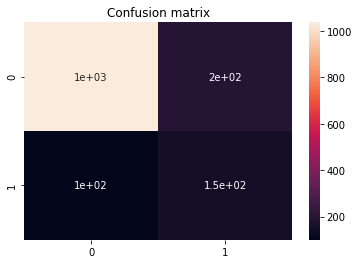

In [182]:
cm=confusion_matrix(y_train,y_train_pred_best)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")      
plt.show()

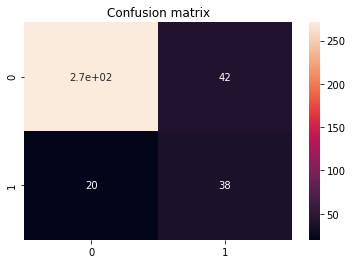

In [183]:
cm=confusion_matrix(y_test,y_test_pred_best)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")   
plt.show()

Se reajustó el modelo para una variedad de combinaciones de valores específicos para cada uno de los hiperparámetros. Se ajustaron 239 modelos diferentes, y se identificó el mejor modelo a aquel que tiene los siguientes parámetros:

- alpha': 0.0001,
- 'penalty': 'l1',
- 'loss': 'log'

En comparación con el modelo estimado empleando los parámetros por default, podríamos decir que los resultados que obtenemos son levemente mejores.


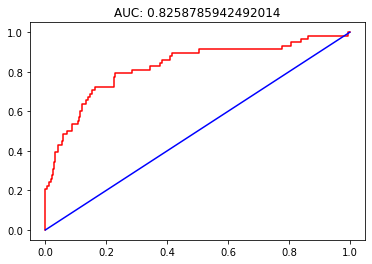

In [184]:
def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()
    
plot_roc_auc(y_test, model.predict_proba(X_test))

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


#### Ajustamos el modelo

In [185]:
model=DecisionTreeClassifier(random_state=0) 
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

#### Predecimos y obtenemos las métricas

In [186]:
y_train_pred= model.predict(X_train)
y_test_pred=model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred))

print("TESTEO")
print(classification_report(y_test, y_test_pred))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483

TESTEO
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



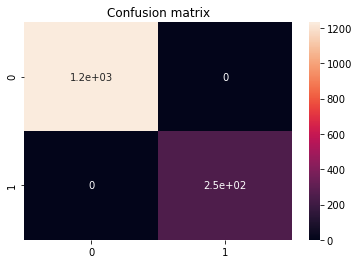

In [187]:
cm=confusion_matrix(y_train,y_train_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")      
plt.show()

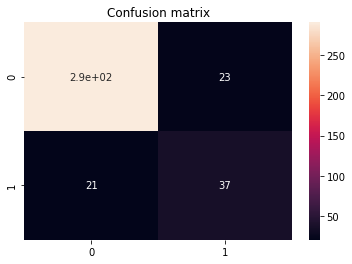

In [188]:
cm=confusion_matrix(y_test,y_test_pred)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")   #En este caso, la matriz de confusión que genera es más razonable. Aunque tiene una mayoría de casos etiquetados como 0 correctamente
plt.show()

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### Definimos una grilla de parámetros

In [189]:
param_grid = {
    "criterion": ["gini", "entropy"],
    'max_depth': [2, 4, 15],
    "min_samples_leaf": [5, 10, 20]
}

#### Hacemos la validación cruzada con el modelo de descenso de árbol de desición y la grilla de hiperparámetros que queremos probar 

In [190]:
model = DecisionTreeClassifier(random_state=0)

cv = GridSearchCV(model, param_grid, scoring='f1', cv=5)
cv.fit(X, y);

In [191]:
results = cv.cv_results_

In [192]:
df = pd.DataFrame(results)
df[['param_criterion', 'param_max_depth', "param_min_samples_leaf",'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,std_test_score,rank_test_score
0,gini,2,5,0.413796,0.054418,15
1,gini,2,10,0.420744,0.063772,9
2,gini,2,20,0.420744,0.063772,9
3,gini,4,5,0.430900,0.116486,7
4,gini,4,10,0.476730,0.110441,2
5,gini,4,20,0.466840,0.113642,3
6,gini,15,5,0.451810,0.076669,5
7,gini,15,10,0.499885,0.091235,1
8,gini,15,20,0.466345,0.112283,4
9,entropy,2,5,0.416575,0.099494,12


In [193]:
cv.best_estimator_

DecisionTreeClassifier(max_depth=15, min_samples_leaf=10, random_state=0)

In [25]:
cv.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10}

#### Evaluamos, predecimos y obtenemos las métricas del mejor modelo obtenido a partir de los datos de entrenamiento y test

In [26]:
best_model=DecisionTreeClassifier(criterion="gini", max_depth=4, min_samples_leaf=10, random_state=0)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=0)

In [27]:
y_train_pred_best= best_model.predict(X_train)
y_test_pred_best= best_model.predict(X_test)

print("ENTRENAMIENTO")
print(classification_report(y_train, y_train_pred_best))

print("TESTEO")
print(classification_report(y_test, y_test_pred_best))

ENTRENAMIENTO
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1232
           1       0.88      0.42      0.57       251

    accuracy                           0.89      1483
   macro avg       0.89      0.71      0.76      1483
weighted avg       0.89      0.89      0.88      1483

TESTEO
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       313
           1       0.76      0.43      0.55        58

    accuracy                           0.89       371
   macro avg       0.83      0.70      0.74       371
weighted avg       0.88      0.89      0.88       371



In [ ]:
cm=confusion_matrix(y_train,y_train_pred_best)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")      
plt.show()

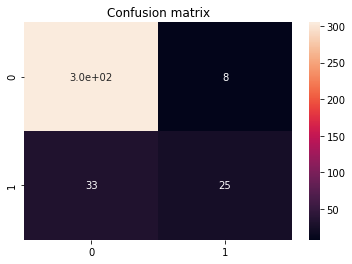

In [34]:
cm=confusion_matrix(y_test,y_test_pred_best)

sns.heatmap(cm, annot=True)

plt.title("Confusion matrix")
plt.show()

In [28]:
#Entre las dos matrices de confusión. Se redujeron la cantidad de casos clasificados en 1 correctamente y los clasficados como 0 erróenamente
#pero aumentaron los casos clasificados como 0 correctamente y 1 erróneamente

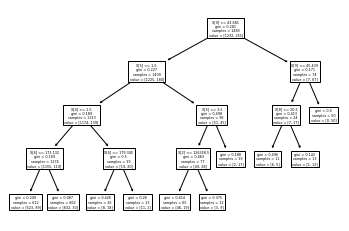

In [29]:
plot_tree(best_model);

Se reajustó el modelo para una variedad de combinaciones de valores específicos para cada uno de los hiperparámetros. Se ajustaron 17 modelos diferentes, y se identificó el mejor modelo a aquel que tiene los siguientes parámetros:


- 'criterion': 'gini', 
- 'max_depth': 4, 
- 'min_samples_leaf': 10

Este modelo, presentó una accuracy promedio de 0.89.

En comparación con el modelo estimado empleando los parámetros por default, podríamos decir que la accuracy promedio del conjunto de test mejora solo levemente (de 0.88 a 0.89). 
En cuanto a las otras métricas, el mejor modelo encontrado presenta ... 
**(FC: tengo dudas sobre la comparación entre las métricas, cuál debería mirar? No tendría sentido, en principio hasta el mejor modelo no parecía el mejor para predicción de la clase minoritaria, clientes en default)**

Si tal cual, misma duda. Lo que si creo es que el modelo del árbol de decisión es mejor que el de descenso de gradiente ya que éste último predice muy mal a la clase 1 (LAU)